In [1]:
import numpy as np
from project import Phase
import torch
import sys
from matplotlib import pyplot as plt
from mpi4py import MPI
from tqdm import tqdm
import timeit

constants = {}
constants['progress'] = False
constants['c'] = 1.42
constants['Aeff'] = 7.29
constants['t_final'] = 300
constants['sim_method'] = 'discrete'
constants['ul_coord'] = [1500, 2800]
constants['lr_coord'] = [2723, 3905]
'''Should just set this to min tau_vec I think, which it basically already is'''
constants['min_tau'] = 2
constants['A_cell'] = 270**2 / 1e6 #km^2
constants['ncell_min'] = 2_500
constants['root'] = 0 #For mpi
constants.update({'final_max_tau': np.nan})
constants['meta_metric'] = 'gte_thresh'
constants.update({'metric': 'lambda_s'})
constants.update({'tauc_method': 'flat'})
constants.update({'overwrite_metrics': False}) 
constants['overwrite_results'] = False
#constants['num_train'] = 2_000_000
constants['num_train'] = 10

pproc = Phase(**constants)
pproc.initialize()
assert pproc.metric_exp_spl(pproc.min_tau) > 0

#### Get samples of each parameter we want to train on ####

# Function to return parameter combinations as dicts
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

# For sampling from various probability distributions
rng = np.random.default_rng()

# Theoretical (or ad-hoc) maxima/minima for parameters
minima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(0.02*pproc.ncell_tot),
    'slice_left': int(0.* pproc.ncell_tot),
    'mu_tau': -10.,
    'sigm_tau': 0.,
    'mu_tauc': -10.,
    'sigm_tauc': 0.
}
maxima = {
    'C': 5.*pproc.ncell_tot,
    'ncell': int(1. * pproc.slice_right_max),
    'slice_left': int(1.*pproc.ncell_tot),
    'mu_tau': 0.,
    'sigm_tau': 6.,
    'mu_tauc': 0.,
    'sigm_tauc': 6.
}
param_keys = np.array(list(minima.keys()))

# Start timer to track runtime
start_time = timeit.default_timer()

# Generate parameter values for training
train_x = np.full((pproc.num_train, len(minima)), np.nan)
for param_i, ((key1, _min), (key2, _max)) in enumerate(zip(minima.items(), maxima.items())):
    assert(key1 == key2); key = key1 = key2

    try:
        assert (type(_min)==type(_min))
        _type = type(_min)
    except:
        print('hey thats bad', type(_min), type(_min)); sys.exit()

    # Skip slice_left for now, sample after ncell has been sampled
    if key == 'slice_left': continue

    if _type == float:
        param_samples = rng.uniform(_min, _max, len(train_x))
    elif _type == int:
        param_samples = rng.integers(_min, _max, len(train_x))
    train_x[:, param_i] = param_samples
# Sample slice_left only where feasible given ncell samples
ncell_column = np.nonzero(param_keys == 'ncell')[0][0]
slice_left_max_vec = pproc.slice_right_max - train_x[:,ncell_column]
slice_left_column = np.nonzero(param_keys == 'slice_left')[0][0]
train_x[:, slice_left_column] = rng.uniform(0, slice_left_max_vec)



pproc.tau_expect = np.tile(pproc.tau_flat, (len(train_x), 1))

pproc.mu_tau = train_x[:,3]
pproc.sigm_tau = train_x[:,4]
pproc.generate_eps_tau_vectorized()
pproc.tau_expect += pproc.eps_tau

pproc.change_tau_expect_vectorized(train_x[:,0], 
                                   train_x[:,1].astype(int), 
                                   train_x[:,2].astype(int),
                                   train_x[:,5], 
                                   train_x[:,6])

pproc.calculate_metric_gte(vectorized=True)

[Mac.search.charter.net:29356] shmem: mmap: an error occurred while determining whether or not /var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T//ompi.Mac.501/jf.0/3374448640/sm_segment.Mac.501.c9220000.0 could be created.
/Users/patrick/Research/Regan/TecateCypress/sensitivity/project.py:371: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/self.c)


[-7.91936959 -5.16604849 -8.79535936] [0.20146092 0.46213721 0.22403708]
-7.918597128387139 0.20104905713373694
-5.164249140251883 0.4610678024489767
-8.794926723822448 0.22387757575244935


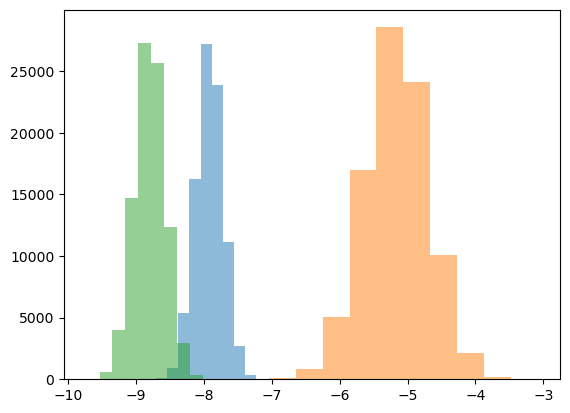

In [2]:
print(pproc.mu_tau, pproc.sigm_tau)
for i in range(len(train_x)):
    plt.hist(pproc.eps_tau[i,:], alpha=0.5);
    print(np.mean(pproc.eps_tau[i,:]), np.std(pproc.eps_tau[i,:]))

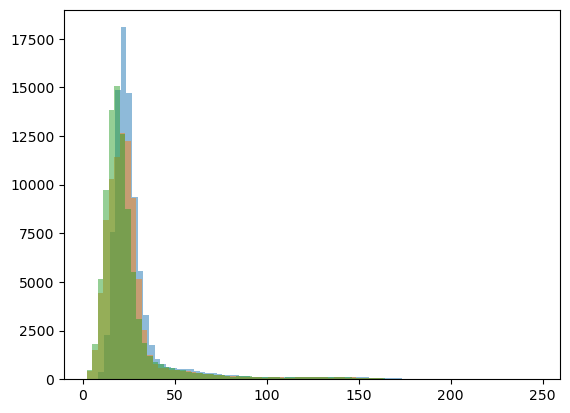

In [13]:
for i in range(len(train_x)):
    plt.hist(pproc.tau_expect[i,:], alpha=0.5, bins=80);
    # plt.show()

In [8]:
C = train_x[0,0]
ncell = int(train_x[0,1])
slice_left = int(train_x[0,2])
pproc.mu_tauc = train_x[0,5]
pproc.sigm_tauc = train_x[0,6]

def change_tau_expect(pproc, C, ncell, slice_left)
    slice_indices = pproc.tau_argsort_ref[slice_left:slice_left + ncell]
    tau_slice = pproc.tau_expect[slice_indices]
    # Set max tauc per cell
    final_max_tauc = pproc.final_max_tau - tau_slice
    # First create array of replacement tau
    replacement_tau = np.ones(ncell) #Initialize

    tauc = C / ncell
    tauc_slice = np.repeat(tauc, ncell)

    # Add uncertainty to tauc slice
    pproc.eps_tauc = pproc.rng.normal(loc=pproc.mu_tauc, scale=pproc.sigm_tauc, size=ncell) 
    tauc_slice = tauc_slice + pproc.eps_tauc

    # Find where tauc will push tau beyond max
    xs_filt = (tauc_slice > final_max_tauc) 
    replacement_tau[xs_filt] = pproc.final_max_tau
    replacement_tau[xs_filt==False] = (tau_slice + tauc_slice)[xs_filt==False]

    # Now replace them in the full array of tau
    pproc.tau_expect[slice_indices] = replacement_tau 

    # Replace any tau lt min with min
    pproc.tau_expect = np.where(pproc.tau_expect < pproc.min_tau, pproc.min_tau, pproc.tau_expect)

IndexError: index 38422 is out of bounds for axis 0 with size 3

In [2]:
def change_tau_expect_vectorized(pproc, C_vec, ncell_vec, slice_left_vec, mu_tauc_vec, sigm_tauc_vec):
    """
    Vectorized-over-samples but looped-per-sample tau update.

    Parameters:
        pproc: An object with:
            - tau_expect: ndarray (n_samples, ncell_tot)
            - tau_argsort_ref: 1D array of shape (ncell_tot,)
            - final_max_tau: scalar
            - min_tau: scalar
            - rng: NumPy-compatible RNG with normal()
        C_vec: (n_samples,) array
        ncell_vec: (n_samples,) array of ints
        slice_left_vec: (n_samples,) array of ints
        mu_tauc_vec: (n_samples,) array
        sigm_tauc_vec: (n_samples,) array
    """
    n_samples = len(C_vec)
    tau_expect_out = np.copy(pproc.tau_expect)

    for i in range(n_samples):
        C = C_vec[i]
        ncell = ncell_vec[i]
        slice_left = slice_left_vec[i]
        mu_tauc = mu_tauc_vec[i]
        sigm_tauc = sigm_tauc_vec[i]

        # 1. Get indices for this sample
        slice_indices = pproc.tau_argsort_ref[slice_left:slice_left + ncell]

        # 2. Extract current tau slice
        tau_slice = tau_expect_out[i, slice_indices]
        final_max_tauc = pproc.final_max_tau - tau_slice

        # 3. Compute tauc with noise
        tauc = C / ncell
        tauc_slice = np.full(ncell, tauc)
        eps_tauc = pproc.rng.normal(loc=mu_tauc, scale=sigm_tauc, size=ncell)
        tauc_slice += eps_tauc

        # 4. Apply capping logic
        replacement_tau = np.where(
            tauc_slice > final_max_tauc,
            pproc.final_max_tau,
            tau_slice + tauc_slice
        )

        # 5. Insert back into tau_expect
        tau_expect_out[i, slice_indices] = replacement_tau

    # 6. Clip with min_tau
    pproc.tau_expect = np.where(tau_expect_out < pproc.min_tau, pproc.min_tau, tau_expect_out)

In [24]:
import numba

@numba.njit
def change_tau_expect_numba(
    tau_expect, tau_argsort_ref, C_vec, ncell_vec, slice_left_vec,
    mu_tauc_vec, sigm_tauc_vec, final_max_tau, min_tau, eps_tauc_all
):
    n_samples, ncell_tot = tau_expect.shape

    for i in range(n_samples):
        C = C_vec[i]
        ncell = ncell_vec[i]
        slice_left = slice_left_vec[i]
        mu_tauc = mu_tauc_vec[i]
        sigm_tauc = sigm_tauc_vec[i]

        slice_indices = tau_argsort_ref[slice_left:slice_left + ncell]
        tau_slice = tau_expect[i, slice_indices]
        final_max_tauc = final_max_tau - tau_slice

        tauc = C / ncell
        tauc_slice = np.full(ncell, tauc)
        tauc_slice += eps_tauc_all[i, :ncell]

        replacement_tau = np.empty(ncell)
        for j in range(ncell):
            if tauc_slice[j] > final_max_tauc[j]:
                replacement_tau[j] = final_max_tau
            else:
                replacement_tau[j] = tau_slice[j] + tauc_slice[j]

        for j in range(ncell):
            tau_expect[i, slice_indices[j]] = replacement_tau[j]

    # Clip to min_tau
    for i in range(n_samples):
        for j in range(ncell_tot):
            if tau_expect[i, j] < min_tau:
                tau_expect[i, j] = min_tau

    return tau_expect

In [67]:
# Reset tau_expect before calculation
pproc.tau_expect = np.tile(pproc.tau_flat, (len(train_x), 1))
pproc.generate_eps_tau_vectorized()
pproc.tau_expect += pproc.eps_tau

start_time = timeit.default_timer()
change_tau_expect_vectorized(pproc, train_x[:,0], train_x[:,1].astype(int), train_x[:,2].astype(int), 
                             train_x[:,5], train_x[:,6])
print(f"{timeit.default_timer() - start_time} seconds")

# for i in range(len(train_x)):
#     plt.hist(pproc.tau_expect[i,:], alpha=0.5, bins=80);
# plt.show()


C_vec = train_x[:,0]
ncell_vec = train_x[:,1].astype(int)
slice_left_vec = train_x[:,2].astype(int)
mu_tauc_vec = train_x[:,5]
sigm_tauc_vec = train_x[:,6]

# Reset tau_expect before calculation
pproc.tau_expect = np.tile(pproc.tau_flat, (len(train_x), 1))
pproc.generate_eps_tau_vectorized()
pproc.tau_expect += pproc.eps_tau

start_time = timeit.default_timer()

eps_tauc_all = np.array([
    pproc.rng.normal(loc=mu, scale=sig, size=ncell)
    for mu, sig, ncell in zip(mu_tauc_vec, sigm_tauc_vec, ncell_vec)
], dtype=object)

# Convert to 2D padded array (max_ncell), or preallocate with max shape
max_ncell = max(ncell_vec)
eps_tauc_pad = np.zeros((len(ncell_vec), max_ncell))
for i, eps in enumerate(eps_tauc_all):
    eps_tauc_pad[i, :len(eps)] = eps  # pad with zeros (or sentinel)

# Call compiled version
pproc.tau_expect = change_tau_expect_numba(
    pproc.tau_expect.copy(),
    pproc.tau_argsort_ref,
    C_vec,
    ncell_vec,
    slice_left_vec,
    mu_tauc_vec,
    sigm_tauc_vec,
    pproc.final_max_tau,
    pproc.min_tau,
    eps_tauc_pad,
)

print(f"{timeit.default_timer() - start_time} seconds")

# for i in range(len(train_x)):
#     plt.hist(pproc.tau_expect[i,:], alpha=0.5, bins=80);
# plt.show()

0.6186176250048447 seconds
0.532380375007051 seconds
